In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

# Select nbody6 simulation and snapshot, then convert to physical units and save as a cluster table which SPISEA can interface with

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma1p0/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass             e                log_a               age        
------------------- ---------- --------------------- ------------------- ------------------ ------------------ ------------------
  56.24521950614411        0.0                    []   56.24521950614411                nan                nan  1.494411190854979
0.11411525852041825        0.0                    [] 0.11411525852041825                nan                nan 1.5011385289993755
  12.96283688892593        0.0                    []   12.96283688892593                nan                nan 1.4970749668953602
0.27321673034539384        0.0                    [] 0.27321673034539384                nan                nan 1.4964816285263873
                ...        ...                   ...                 ...                ...                ...                ...
0.20449300038109305        1.0 [0.11248395795903553] 0.31697695834012857   0.2989732941710

# Read ages of stars, identify bracketing ages for isochrone generation
Also save mass of stars

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 6.172382928762329
Max log age = 6.182058450993647
Min level age = 1487246.4082493563
Max level age = 1520752.191543579


# Identify binary stars in cluster table, save mass of companion stars

Cluster table always lists binaries last, so finding the index of the first binary suffices

In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
# print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
# print(compMasses)

# Create histogram of mass ratios pre-processing

(array([  3.,  14.,  69., 121., 181., 124., 134., 141., 120., 132.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

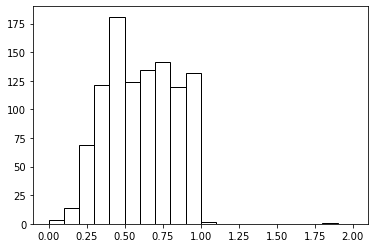

In [6]:
ratios = []
for i in range(len(compMasses)):
    ratios.append(compMasses[i] / masses[i + first_binary])
    # print(ratios[i])

py.hist(ratios, bins=20, range=[0, 2], fill=False)

# Generate isochrones using parameter and age arrays

In [7]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.         6.17609126 6.30103   ]
[1000000. 1500000. 2000000.]


In [8]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


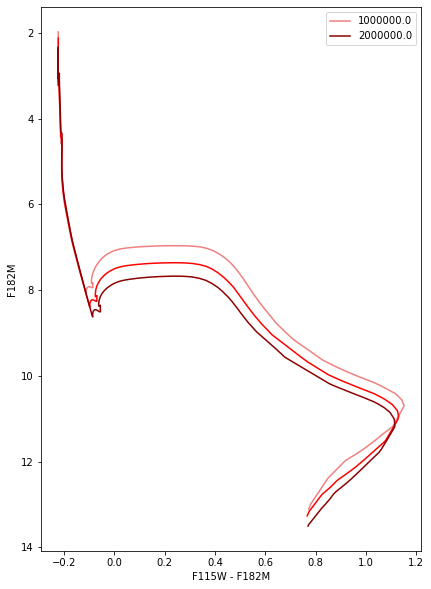

In [9]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# Use generated SPISEA isochrones to find interpolated magnitudes using the age and mass of each star

Stars outside of the mass range of isochrones are thrown out and not included

In [10]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/')
import interpolator as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
# for i in range(len(stars)):
    # print(stars[i])

Desired mass 0.07746465814392134 is outside the range of the isochrone.
Desired mass 0.07746465814392134 is outside the range of the isochrone.
Desired mass 0.08466339817270757 is outside the range of the isochrone.
Desired mass 0.08466339817270757 is outside the range of the isochrone.
Desired mass 0.08217508690946722 is outside the range of the isochrone.
Desired mass 0.08217508690946722 is outside the range of the isochrone.
Desired mass 0.09649129577108034 is outside the range of the isochrone.
Desired mass 0.09649129577108034 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 0.09262585734238067 is outside the range of the isochrone.
Desired mass 0.09262585734238067 is outside the range of the isochrone.
Desired mass 0.07831495046053252 is outside the range of the isochrone.
Desired mass 0.07831495046053252 is outside the range of the isoch

Desired mass 0.03321996433615414 is outside the range of the isochrone.
Desired mass 0.03321996433615414 is outside the range of the isochrone.
Desired mass 0.024887728241640764 is outside the range of the isochrone.
Desired mass 0.024887728241640764 is outside the range of the isochrone.
Desired mass 0.07030582510651515 is outside the range of the isochrone.
Desired mass 0.07030582510651515 is outside the range of the isochrone.
Desired mass 0.072721884219865 is outside the range of the isochrone.
Desired mass 0.072721884219865 is outside the range of the isochrone.
Desired mass 0.028232072062169017 is outside the range of the isochrone.
Desired mass 0.028232072062169017 is outside the range of the isochrone.
Desired mass 0.017976957685676934 is outside the range of the isochrone.
Desired mass 0.017976957685676934 is outside the range of the isochrone.
Desired mass 0.08716310826960777 is outside the range of the isochrone.
Desired mass 0.08716310826960777 is outside the range of the i

Desired mass 0.05330807330178662 is outside the range of the isochrone.
Desired mass 0.05330807330178662 is outside the range of the isochrone.
Desired mass 0.10425630823056005 is outside the range of the isochrone.
Desired mass 0.08920714019929153 is outside the range of the isochrone.
Desired mass 0.08920714019929153 is outside the range of the isochrone.
Desired mass 0.034326161441067565 is outside the range of the isochrone.
Desired mass 0.034326161441067565 is outside the range of the isochrone.
Desired mass 0.07771368490454565 is outside the range of the isochrone.
Desired mass 0.07771368490454565 is outside the range of the isochrone.
Desired mass 0.06637263324558035 is outside the range of the isochrone.
Desired mass 0.06637263324558035 is outside the range of the isochrone.
Desired mass 0.051738613254898994 is outside the range of the isochrone.
Desired mass 0.051738613254898994 is outside the range of the isochrone.
Desired mass 0.03590986775175264 is outside the range of the

Desired mass 0.06200176302322417 is outside the range of the isochrone.
Desired mass 0.06200176302322417 is outside the range of the isochrone.
Desired mass 0.01694218954255395 is outside the range of the isochrone.
Desired mass 0.01694218954255395 is outside the range of the isochrone.
Desired mass 0.09171953488443965 is outside the range of the isochrone.
Desired mass 0.09171953488443965 is outside the range of the isochrone.
Desired mass 0.08093899556001816 is outside the range of the isochrone.
Desired mass 0.08093899556001816 is outside the range of the isochrone.
Desired mass 0.04293315958777513 is outside the range of the isochrone.
Desired mass 0.04293315958777513 is outside the range of the isochrone.
Desired mass 0.037268169778535094 is outside the range of the isochrone.
Desired mass 0.037268169778535094 is outside the range of the isochrone.
Desired mass 0.030670575167798916 is outside the range of the isochrone.
Desired mass 0.030670575167798916 is outside the range of the

Desired mass 0.037294524692833314 is outside the range of the isochrone.
Desired mass 0.037294524692833314 is outside the range of the isochrone.
Desired mass 0.024006097850864123 is outside the range of the isochrone.
Desired mass 0.024006097850864123 is outside the range of the isochrone.
Desired mass 0.05722340100015755 is outside the range of the isochrone.
Desired mass 0.05722340100015755 is outside the range of the isochrone.
Desired mass 0.07087452883542107 is outside the range of the isochrone.
Desired mass 0.07087452883542107 is outside the range of the isochrone.
Desired mass 0.07071826057460112 is outside the range of the isochrone.
Desired mass 0.07071826057460112 is outside the range of the isochrone.
Desired mass 0.08659923537455158 is outside the range of the isochrone.
Desired mass 0.08659923537455158 is outside the range of the isochrone.
Desired mass 0.01101603187550404 is outside the range of the isochrone.
Desired mass 0.01101603187550404 is outside the range of the

Desired mass 0.05985740492817031 is outside the range of the isochrone.
Desired mass 0.05985740492817031 is outside the range of the isochrone.
Desired mass 0.08003283349859563 is outside the range of the isochrone.
Desired mass 0.08003283349859563 is outside the range of the isochrone.
Desired mass 0.012830863725706305 is outside the range of the isochrone.
Desired mass 0.012830863725706305 is outside the range of the isochrone.
Desired mass 0.01592489158291225 is outside the range of the isochrone.
Desired mass 0.01592489158291225 is outside the range of the isochrone.
Desired mass 0.021059727735743935 is outside the range of the isochrone.
Desired mass 0.021059727735743935 is outside the range of the isochrone.
Desired mass 0.09981193244319352 is outside the range of the isochrone.
Desired mass 0.09981193244319352 is outside the range of the isochrone.
Desired mass 0.03252210208887742 is outside the range of the isochrone.
Desired mass 0.03252210208887742 is outside the range of the

Desired mass 0.03853313641007861 is outside the range of the isochrone.
Desired mass 0.03853313641007861 is outside the range of the isochrone.
Desired mass 0.09654924284004035 is outside the range of the isochrone.
Desired mass 0.09654924284004035 is outside the range of the isochrone.
Desired mass 0.08807359889584822 is outside the range of the isochrone.
Desired mass 0.08807359889584822 is outside the range of the isochrone.
Desired mass 0.07923250503169696 is outside the range of the isochrone.
Desired mass 0.07923250503169696 is outside the range of the isochrone.
Desired mass 0.03628742553361701 is outside the range of the isochrone.
Desired mass 0.03628742553361701 is outside the range of the isochrone.
Desired mass 0.06153776614547904 is outside the range of the isochrone.
Desired mass 0.06153776614547904 is outside the range of the isochrone.
Desired mass 0.02640447135116942 is outside the range of the isochrone.
Desired mass 0.02640447135116942 is outside the range of the iso

Desired mass 0.05445120441756373 is outside the range of the isochrone.
Desired mass 0.05445120441756373 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.


# Repeat interpolation on companion stars

Companion stars assumed to be the same age as primary star within system

In [11]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun
    
count = 0
for i in range(len(companions)):
    if companions[i] is None:
        count = count + 1
        continue
    print(companions[i])

print(count)
print(len(companions))


Desired mass 0.09636490446440792 is outside the range of the isochrone.
Desired mass 0.09636490446440792 is outside the range of the isochrone.
Desired mass 0.07471903553293849 is outside the range of the isochrone.
Desired mass 0.07471903553293849 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.09389877662294215 is outside the range of the isochrone.
Desired mass 0.09389877662294215 is outside the range of the isochrone.
Desired mass 0.10166459547430746 is outside the range of the isochrone.
Desired mass 0.10166459547430746 is outside the range of the isochrone.
Desired mass 0.09223736189469771 is outside the range of the isochrone.
Desired mass 0.09223736189469771 is outside the range of the isochrone.
Desired mass 0.08370963329421344 is outside the range of the isochrone.
Desired mass 0.08370963329421344 is outside the range of the iso

Desired mass 0.10404063535119741 is outside the range of the isochrone.
Desired mass 0.07241173322458895 is outside the range of the isochrone.
Desired mass 0.07241173322458895 is outside the range of the isochrone.
Desired mass 0.09626181033490293 is outside the range of the isochrone.
Desired mass 0.09626181033490293 is outside the range of the isochrone.
Desired mass 0.07137144040838675 is outside the range of the isochrone.
Desired mass 0.07137144040838675 is outside the range of the isochrone.
Desired mass 0.08264342107234238 is outside the range of the isochrone.
Desired mass 0.08264342107234238 is outside the range of the isochrone.
Desired mass 0.08836970196810316 is outside the range of the isochrone.
Desired mass 0.08836970196810316 is outside the range of the isochrone.
Desired mass 0.06618053698646982 is outside the range of the isochrone.
Desired mass 0.06618053698646982 is outside the range of the isochrone.
Desired mass 0.06732003499886069 is outside the range of the iso

Desired mass 0.10418842276963994 is outside the range of the isochrone.
Desired mass 0.09806899008801064 is outside the range of the isochrone.
Desired mass 0.09806899008801064 is outside the range of the isochrone.
Desired mass 0.06343453851474662 is outside the range of the isochrone.
Desired mass 0.06343453851474662 is outside the range of the isochrone.
Desired mass 0.05378693756462908 is outside the range of the isochrone.
Desired mass 0.05378693756462908 is outside the range of the isochrone.
Desired mass 0.08900313084411571 is outside the range of the isochrone.
Desired mass 0.08900313084411571 is outside the range of the isochrone.
Desired mass 0.06956745444329208 is outside the range of the isochrone.
Desired mass 0.06956745444329208 is outside the range of the isochrone.
Desired mass 0.0988382739053451 is outside the range of the isochrone.
Desired mass 0.0988382739053451 is outside the range of the isochrone.
Desired mass 0.04540920925769429 is outside the range of the isoch

[7349.717436096282, 26173.776, 4.234, 6.321, 6.501]
[0.9622888219255754, 4169.965, 3.781, 11.51, 10.461]
[0.4997729280681768, 3788.054, 3.724, 12.122, 10.994]
[0.069117095409665, 3005.252, 3.507, 13.919, 13.142]
[0.0927607782629936, 3080.008, 3.521, 13.633, 12.814]
[0.10575557424333414, 3126.214, 3.542, 13.511, 12.665]
[0.3354559163865813, 3571.185, 3.673, 12.467, 11.375]
[1049034.905511648, 50454.628, 4.053, 2.849, 3.071]
[0.06687076196605105, 2998.878, 3.509, 13.953, 13.179]
[0.09905892758439777, 3101.874, 3.531, 13.571, 12.741]
[0.3983809076885961, 3664.836, 3.699, 12.316, 11.207]
[0.09295762997664786, 3084.405, 3.528, 13.634, 12.813]
[0.11093862117249058, 3142.513, 3.548, 13.466, 12.61]
[0.2123357715735197, 3375.566, 3.63, 12.872, 11.858]
[0.46011275219740433, 3740.611, 3.713, 12.192, 11.07]
[0.08409052566220611, 3053.405, 3.514, 13.727, 12.922]
[0.08420170270971218, 3055.477, 3.517, 13.727, 12.921]
[0.37560715201373, 3631.206, 3.69, 12.367, 11.263]
[0.3111136907061047, 3538.102, 3

# Determine mass ratios after filtering, create plots

In [12]:
new_ratios = []
for i in range(len(companions)):
    if companions[i] is None:
        continue
    new_ratios.append(compMasses[i] / masses[i + first_binary])


(array([  3.,  14.,  69., 121., 181., 124., 134., 141., 120., 132.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

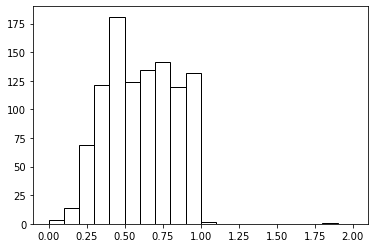

In [24]:
py.hist(ratios, bins=20, range=[0,2], fill=False)

(array([ 1.,  0., 20., 31., 69., 47., 51., 68., 49., 70.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

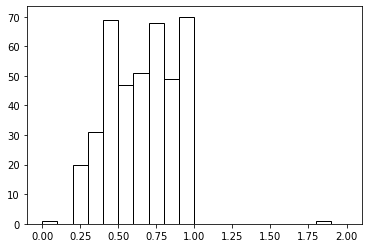

In [25]:
py.hist(new_ratios, bins=20, range=[0,2], fill=False)

# Superimpose primary stars and companion stars against isochrones separately

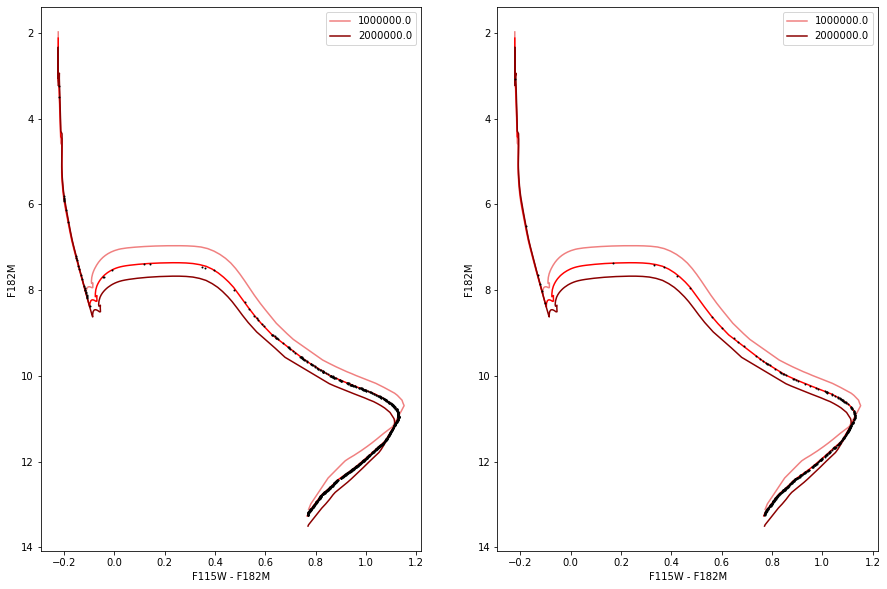

In [15]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# Convert binary stars into unresolved binaries
## Also compute flux ratios of stars and generate histogram
Magnitudes of primary and secondary are converted into flux, which is used to find combined magnitude

In [16]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

flux_ratios = []

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
    flux_ratios.append(flux11 / flux21)
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries[i] = [mag1, mag2]

(array([  0.,   3.,   2., 129.,  81.,  47.,  30.,  34.,  13.,  15.,  17.,
          7.,   8.,   5.,   2.,   4.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.]),
 array([ 0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
         1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ,
         3.33333333,  3.66666667,  4.        ,  4.33333333,  4.66666667,
         5.        ,  5.33333333,  5.66666667,  6.        ,  6.33333333,
         6.66666667,  7.        ,  7.33333333,  7.66666667,  8.        ,
         8.33333333,  8.66666667,  9.        ,  9.33333333,  9.66666667,
        10.        ]),
 <BarContainer object of 30 artists>)

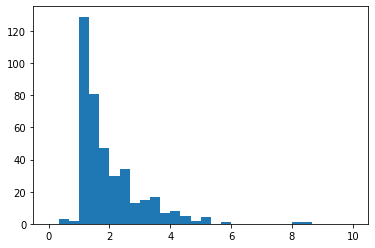

In [17]:
py.hist(flux_ratios, bins=30, range=[0,10])

# Generate CMD using star array, plus unresolved binaries
Compare to CMD generated by simply multiplying each star's flux by 2

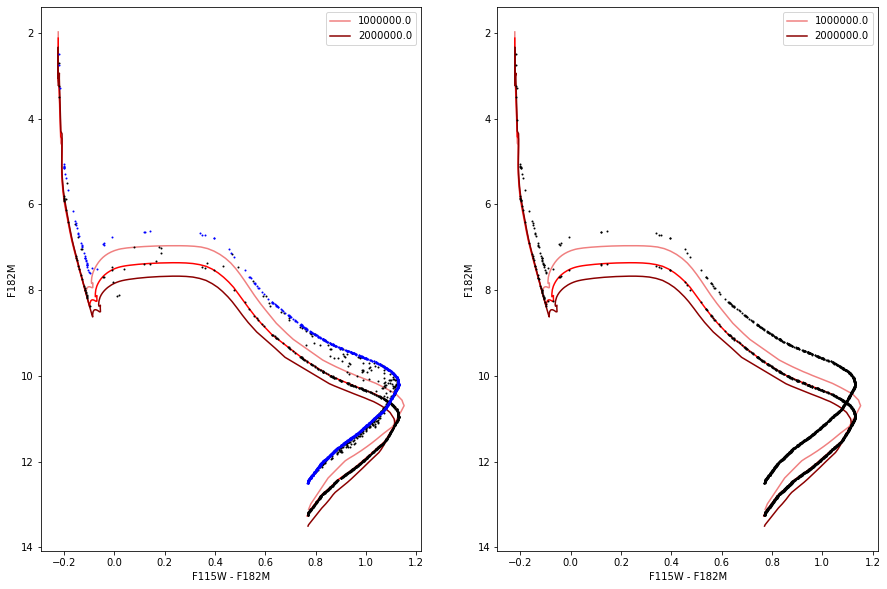

In [18]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(unresolved_binaries[i][0] - unresolved_binaries[i][1], unresolved_binaries[i][1], marker='o', markersize=1, color='k')
    
for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='blue')
    
# plot toy scalar multiple track
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='k')